# groub

In [1]:
import pandas as pd
import glob
import os

folder_path = "PROBE-202412"
output_file = "one_for_all.csv"

columns = ["vehicle_id", "gpsvalid", "lat", "lon", "timestamp", "speed", "heading", "for_hire_light", "engine_acc"]

file_list = glob.glob(os.path.join(folder_path, "*.csv.out"))

# Remove output if it exists, so we can start clean
if os.path.exists(output_file):
    os.remove(output_file)

# Write header once at the beginning
with open(output_file, "w") as f:
    f.write(",".join(columns) + "\n")

# Process each file one by one, in chunks
for file in file_list:
    print(f"Processing {file} ...")
    try:
        # Read in small chunks (adjust chunksize depending on your RAM)
        for chunk in pd.read_csv(file, header=None, names=columns, chunksize=200_000):
            # Write directly to the output CSV (no sorting yet)
            chunk.to_csv(output_file, mode="a", index=False, header=False)
    except Exception as e:
        print(f"⚠️ Error reading {file}: {e}")

print("✅ Finished merging all files into 'one_for_all.csv'")



Processing PROBE-202412\20241201.csv.out ...
Processing PROBE-202412\20241202.csv.out ...
Processing PROBE-202412\20241203.csv.out ...
Processing PROBE-202412\20241204.csv.out ...
Processing PROBE-202412\20241205.csv.out ...
Processing PROBE-202412\20241206.csv.out ...
Processing PROBE-202412\20241207.csv.out ...
Processing PROBE-202412\20241208.csv.out ...
Processing PROBE-202412\20241209.csv.out ...
Processing PROBE-202412\20241210.csv.out ...
Processing PROBE-202412\20241211.csv.out ...
Processing PROBE-202412\20241212.csv.out ...
Processing PROBE-202412\20241213.csv.out ...
Processing PROBE-202412\20241214.csv.out ...
Processing PROBE-202412\20241215.csv.out ...
Processing PROBE-202412\20241216.csv.out ...
Processing PROBE-202412\20241217.csv.out ...
Processing PROBE-202412\20241218.csv.out ...
Processing PROBE-202412\20241219.csv.out ...
Processing PROBE-202412\20241220.csv.out ...
Processing PROBE-202412\20241221.csv.out ...
Processing PROBE-202412\20241222.csv.out ...
Processing

# add header

In [1]:
import pandas as pd

# Read the .out file
df = pd.read_csv("20170101.csv.out", header=None, delimiter=",")  # header=None treats first row as data

# Define the column names
columns = ["vehicle_id", "gpsvalid", "lat", "lon", "timestamp", "speed", "heading", "for_hire_light", "engine_acc"]

# Assign the column names to the dataframe
df.columns = columns

# Save as a proper CSV with header
df.to_csv("taxi.csv", index=False)

print("File converted to taxi.csv with header")


File converted to taxi.csv with header


# cleaning part

In [2]:
import pandas as pd

input_file = "one_for_all.csv"
output_file = "vehicle_data_clean.csv"
zero_file = "all_speed_is_0.csv"

chunksize = 200_000  # tune depending on your RAM

vehicle_stats = {}

print("🔍 Pass 1: Analyzing vehicles...")

# Pass 1: collect speed info per vehicle_id
for chunk in pd.read_csv(input_file, chunksize=chunksize):
    for vid, speeds in chunk.groupby("vehicle_id")["speed"]:
        speeds_all_zero = (speeds == 0).all()
        count_rows = len(speeds)
        if vid not in vehicle_stats:
            vehicle_stats[vid] = {"count": count_rows, "all_zero": speeds_all_zero}
        else:
            prev = vehicle_stats[vid]
            vehicle_stats[vid]["count"] = prev["count"] + count_rows
            vehicle_stats[vid]["all_zero"] = prev["all_zero"] and speeds_all_zero

# Determine which vehicles always had speed = 0 and more than 1 row
broke_cars = [vid for vid, v in vehicle_stats.items() if v["all_zero"] and v["count"] > 1]

# Save these vehicles
pd.DataFrame(broke_cars, columns=["vehicle_id"]).to_csv(zero_file, index=False)
print(f"✅ Found {len(broke_cars)} vehicles that always had speed = 0")

print("🧹 Pass 2: Writing cleaned file...")

# Pass 2: write only non-broken cars
first_chunk = True
for chunk in pd.read_csv(input_file, chunksize=chunksize):
    chunk = chunk[~chunk["vehicle_id"].isin(broke_cars)]
    chunk.to_csv(output_file, mode="w" if first_chunk else "a", index=False, header=first_chunk)
    first_chunk = False

print(f"✅ Cleaned file saved as {output_file}")


🔍 Pass 1: Analyzing vehicles...
✅ Found 144 vehicles that always had speed = 0
🧹 Pass 2: Writing cleaned file...
✅ Cleaned file saved as vehicle_data_clean.csv


In [3]:
import pandas as pd
import os

input_file = "vehicle_data_clean.csv"
temp_file = "vehicle_data_filtered.csv"  # temporary output file
chunksize = 200_000  # adjust for your system (lower = less RAM)

vehicle_hired = {}

print("🔍 Pass 1: Checking which vehicles ever had a customer...")

# Pass 1 — collect hire info
for chunk in pd.read_csv(input_file, chunksize=chunksize, usecols=["vehicle_id", "for_hire_light"]):
    # Group by vehicle_id in each chunk
    for vid, vals in chunk.groupby("vehicle_id")["for_hire_light"]:
        ever_hired = (vals == 0).any()  # 0 = has customer
        if vid not in vehicle_hired:
            vehicle_hired[vid] = ever_hired
        else:
            vehicle_hired[vid] = vehicle_hired[vid] or ever_hired

# Identify vehicles that never got any customer
vehicles_never_hired = [vid for vid, hired in vehicle_hired.items() if not hired]
print(f"🚗 Vehicles that never got any customer: {len(vehicles_never_hired)}")

# Pass 2 — filter them out and write to temp file
print("🧹 Pass 2: Writing filtered data...")
first_chunk = True
for chunk in pd.read_csv(input_file, chunksize=chunksize):
    chunk = chunk[~chunk["vehicle_id"].isin(vehicles_never_hired)]
    chunk.to_csv(temp_file, mode="w" if first_chunk else "a", index=False, header=first_chunk)
    first_chunk = False

# Replace the old file
os.replace(temp_file, input_file)

print(f"✅ Done! Cleaned file saved as '{input_file}' (replaced original).")


🔍 Pass 1: Checking which vehicles ever had a customer...
🚗 Vehicles that never got any customer: 498
🧹 Pass 2: Writing filtered data...
✅ Done! Cleaned file saved as 'vehicle_data_clean.csv' (replaced original).


In [ ]:
import pandas as pd
import os

input_file = "vehicle_data_clean.csv"
temp_file = "vehicle_data_no_nan.csv"
chunksize = 200_000  # adjust depending on RAM

nan_counts = None
total_rows = 0
rows_with_nan = 0

print("🔍 Pass 1+2: Dropping rows that contain NaN values...")

first_chunk = True
for chunk in pd.read_csv(input_file, chunksize=chunksize):
    # Count NaNs in this chunk
    chunk_nan_counts = chunk.isna().sum()
    if nan_counts is None:
        nan_counts = chunk_nan_counts
    else:
        nan_counts += chunk_nan_counts

    total_rows += len(chunk)
    rows_with_nan += chunk.isna().any(axis=1).sum()

    # Drop NaN rows and write to output file
    chunk = chunk.dropna()
    chunk.to_csv(temp_file, mode="w" if first_chunk else "a", index=False, header=first_chunk)
    first_chunk = False

# Summary
print("\n📊 NaN counts per column before dropping:")
print(nan_counts)
print(f"\nTotal rows: {total_rows}")
print(f"Rows with at least one NaN: {rows_with_nan}")
print(f"Rows kept: {total_rows - rows_with_nan}")

# Replace the old file
os.replace(temp_file, input_file)
print(f"\n✅ Cleaned file saved (overwritten): '{input_file}'")


🔍 Pass 1+2: Dropping rows that contain NaN values...

📊 NaN counts per column before dropping:
vehicle_id        0
gpsvalid          0
lat               0
lon               0
timestamp         0
speed             0
heading           0
for_hire_light    0
engine_acc        0
dtype: int64

Total rows: 15263328
Rows with at least one NaN: 0
Rows kept: 15263328

✅ Cleaned file saved (overwritten): 'vehicle_data_clean.csv'


In [1]:
import pandas as pd
import os

input_file = "vehicle_data_clean.csv"
temp_file = "vehicle_data_speed_filtered.csv"
chunksize = 200_000  # tune this number to control memory use

print("🚗 Filtering rows where speed > 300 ...")

first_chunk = True
rows_in = 0
rows_out = 0

for chunk in pd.read_csv(input_file, chunksize=chunksize):
    rows_in += len(chunk)

    # Keep only reasonable speeds
    chunk = chunk[chunk["speed"] <= 300]
    rows_out += len(chunk)

    # Write incrementally
    chunk.to_csv(
        temp_file,
        mode="w" if first_chunk else "a",
        index=False,
        header=first_chunk
    )
    first_chunk = False

print(f"✅ Filter complete: kept {rows_out:,} of {rows_in:,} rows")

# Replace original file atomically
os.replace(temp_file, input_file)
print(f"💾 Cleaned file saved as '{input_file}' (original replaced).")


🚗 Filtering rows where speed > 300 ...
✅ Filter complete: kept 15,263,327 of 15,263,328 rows
💾 Cleaned file saved as 'vehicle_data_clean.csv' (original replaced).


# feature engineer part build training set

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Load dataset (assuming df is already loaded with columns: vehicle_id, timestamp, for_hire_light, lat, lon, speed, heading)
df = pd.read_csv("vehicle_data_clean.csv")
# df should have columns: vehicle_id, timestamp, for_hire_light, lat, lon, speed, heading

# Ensure proper timestamp ordering
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["vehicle_id", "timestamp"])

# Shift to detect transitions
df["prev_light"] = df.groupby("vehicle_id")["for_hire_light"].shift(1)

# Identify pickups (1 -> 0) and dropoffs (0 -> 1)
pickups = df[(df["prev_light"] == 1) & (df["for_hire_light"] == 0)].copy()
dropoffs = df[(df["prev_light"] == 0) & (df["for_hire_light"] == 1)].copy()

# Match pickup with the *next* dropoff for the same vehicle
pickups["dropoff_lat"] = np.nan
pickups["dropoff_lon"] = np.nan

for vid in pickups["vehicle_id"].unique():
    p_idx = pickups[pickups["vehicle_id"] == vid].index
    d_idx = dropoffs[dropoffs["vehicle_id"] == vid].index

    # Pair them sequentially
    for pi, di in zip(p_idx, d_idx):
        pickups.loc[pi, "dropoff_lat"] = df.loc[di, "lat"]
        pickups.loc[pi, "dropoff_lon"] = df.loc[di, "lon"]

# Drop rows where dropoff coordinates are missing (if any)
pickups = pickups.dropna(subset=["dropoff_lat", "dropoff_lon"])

# Add heading features (sin and cos of heading in radians)
pickups["sin_heading"] = np.sin(np.radians(pickups["heading"]))
pickups["cos_heading"] = np.cos(np.radians(pickups["heading"]))

# --- KMeans Clustering for Drop-off Zones ---
# Prepare drop-off coordinates for clustering
dropoff_coords = pickups[["dropoff_lat", "dropoff_lon"]].values

# Apply KMeans clustering (choose number of clusters, e.g., 50)
n_clusters = 50  # Adjust based on your dataset size and desired granularity
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pickups["kmeans_zone"] = kmeans.fit_predict(dropoff_coords)

# --- Grid-Based Zoning for Drop-off Points ---
# Define grid size (e.g., 0.01 degrees ~ 1 km depending on location)
grid_size = 0.01

# Create grid cell IDs
pickups["grid_zone"] = (
    (pickups["dropoff_lat"] // grid_size).astype(int) * 1000 + 
    (pickups["dropoff_lon"] // grid_size).astype(int)
)

# Build final training dataset
training = pd.DataFrame({
    "vehicle_id": pickups["vehicle_id"].astype(str),
    "pickup_time": pickups["timestamp"].dt.strftime("%Y-%m-%d %H:%M:%S"),
    "pickup_lat": pickups["lat"].astype(float),
    "pickup_lon": pickups["lon"].astype(float),
    "sin_hour": np.sin(2 * np.pi * pickups["timestamp"].dt.hour / 24),
    "cos_hour": np.cos(2 * np.pi * pickups["timestamp"].dt.hour / 24),
    "pickup_speed": pickups["speed"].astype(float),
    "sin_heading": pickups["sin_heading"].astype(float),  # New heading feature
    "cos_heading": pickups["cos_heading"].astype(float),  # New heading feature
    "kmeans_zone": pickups["kmeans_zone"].astype(int),    # KMeans cluster ID as label
    "grid_zone": pickups["grid_zone"].astype(int),        # Grid cell ID as label
    "dropoff_lat": pickups["dropoff_lat"].astype(float),
    "dropoff_lon": pickups["dropoff_lon"].astype(float),
})

# Save to CSV
training.to_csv("training_rides_with_zones_and_heading.csv", index=False)

print("✅ Training dataset with vehicle_id, pickup_time, kmeans_zone, grid_zone, sin_heading, and cos_heading saved as training_rides_with_zones_and_heading.csv")


✅ Training dataset with vehicle_id, pickup_time, kmeans_zone, grid_zone, sin_heading, and cos_heading saved as training_rides_with_zones_and_heading.csv


# model radom forest regression

Mean Squared Error (MSE): 0.000437
R-squared (R²): 0.989642
Cross-Validated MSE: 0.000649
Average Haversine Error (km): 0.81
Saved predictions with vehicle IDs to predicted_dropoffs.csv


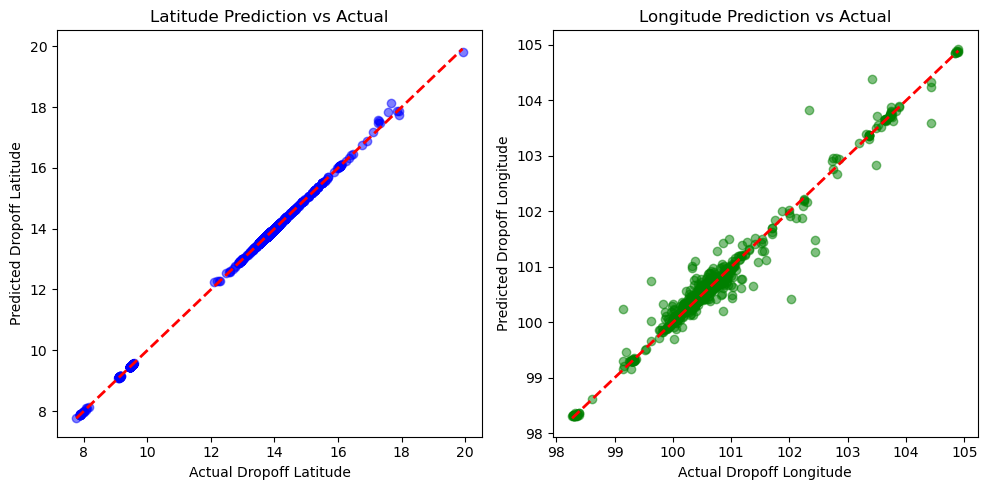

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

# Load the cleaned CSV
df = pd.read_csv('training_rides_with_zones_and_heading.csv')

# Features (X) including heading + zone
X = df[['pickup_lat', 'pickup_lon', 'sin_hour', 'cos_hour', 'pickup_speed',
        'sin_heading', 'cos_heading', 'kmeans_zone', 'grid_zone']]
# Targets (y)
y = df[['dropoff_lat', 'dropoff_lon']]
# Vehicle IDs
vehicle_ids = df['vehicle_id']

# Split data (keep vehicle_id aligned)
X_train, X_test, y_train, y_test, veh_train, veh_test = train_test_split(
    X, y, vehicle_ids, test_size=0.2, random_state=42
)

# Scale features (optional for RF)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train RF model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model = MultiOutputRegressor(rf)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.6f}')
print(f'R-squared (R²): {r2:.6f}')

# Cross-validation (per target, average)
cv_mse_list = []
for i in range(y_train.shape[1]):
    scores = cross_val_score(rf, X_train_scaled, y_train.iloc[:, i], cv=5,
                             scoring='neg_mean_squared_error')
    cv_mse_list.append(-scores.mean())
cv_mse = np.mean(cv_mse_list)
print(f'Cross-Validated MSE: {cv_mse:.6f}')

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Compute Haversine error for each prediction
haversine_errors = [haversine(y_test.iloc[i, 0], y_test.iloc[i, 1],
                              y_pred[i, 0], y_pred[i, 1])
                    for i in range(len(y_test))]
avg_haversine_error = np.mean(haversine_errors)
print(f'Average Haversine Error (km): {avg_haversine_error:.2f}')

# Build prediction DataFrame with vehicle_id
pred_df = pd.DataFrame({
    "vehicle_id": veh_test.values,
    "pickup_lat": X_test['pickup_lat'].values,
    "pickup_lon": X_test['pickup_lon'].values,
    "pred_drop_lat": y_pred[:, 0],
    "pred_drop_lon": y_pred[:, 1],
    "true_drop_lat": y_test['dropoff_lat'].values,
    "true_drop_lon": y_test['dropoff_lon'].values,
    "haversine_error_km": haversine_errors
})

# Save to CSV
pred_df.to_csv("predicted_dropoffs.csv", index=False)
print("Saved predictions with vehicle IDs to predicted_dropoffs.csv")

# Visualization
plt.figure(figsize=(10, 5))

# Latitude plot
plt.subplot(1, 2, 1)
plt.scatter(y_test['dropoff_lat'], y_pred[:, 0], color='blue', alpha=0.5)
plt.plot([y_test['dropoff_lat'].min(), y_test['dropoff_lat'].max()],
         [y_test['dropoff_lat'].min(), y_test['dropoff_lat'].max()], 'r--', lw=2)
plt.xlabel('Actual Dropoff Latitude')
plt.ylabel('Predicted Dropoff Latitude')
plt.title('Latitude Prediction vs Actual')

# Longitude plot
plt.subplot(1, 2, 2)
plt.scatter(y_test['dropoff_lon'], y_pred[:, 1], color='green', alpha=0.5)
plt.plot([y_test['dropoff_lon'].min(), y_test['dropoff_lon'].max()],
         [y_test['dropoff_lon'].min(), y_test['dropoff_lon'].max()], 'r--', lw=2)
plt.xlabel('Actual Dropoff Longitude')
plt.ylabel('Predicted Dropoff Longitude')
plt.title('Longitude Prediction vs Actual')

plt.tight_layout()
plt.show()


# HDBSCAN

In [17]:
import pandas as pd
import numpy as np
import hdbscan
from math import radians, cos, sin, asin, sqrt
from sklearn.metrics import silhouette_score

# Haversine distance (vectorized for efficiency)
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.array, [lat1, lon1, lat2, lon2])
    R = 6371.0  # Earth radius in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Run HDBSCAN clustering
def run_hdbscan(coords, min_cluster_size=5):
    if np.any(np.isnan(coords)):
        raise ValueError("Coordinates contain NaN values")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='haversine')
    labels = clusterer.fit_predict(np.radians(coords))
    return labels, clusterer

# Limit clusters to max_n
def limit_clusters(coords, labels, max_n=1000):
    df = pd.DataFrame(coords, columns=['lat','lon'])
    df['label'] = labels
    cluster_sizes = df['label'].value_counts().to_dict()
    unique_clusters = [c for c in cluster_sizes if c != -1]
    sorted_clusters = sorted(unique_clusters, key=lambda x: cluster_sizes[x], reverse=True)
    keep_clusters = sorted_clusters[:min(max_n, len(sorted_clusters))]
    new_labels = np.where(np.isin(labels, keep_clusters) | (labels == -1), labels, -1)
    return new_labels

# Compute cluster centroids and radius
def cluster_stats(coords, labels):
    clusters = {}
    df = pd.DataFrame(coords, columns=['lat','lon'])
    df['label'] = labels
    for label in set(labels):
        if label == -1:
            continue
        points = df[df['label'] == label][['lat','lon']].values
        if len(points) == 0:
            continue
        center = points.mean(axis=0)
        distances = haversine(center[0], center[1], points[:, 0], points[:, 1])
        radius = np.max(distances)
        clusters[label] = {
            'center_lat': center[0],
            'center_lon': center[1],
            'radius_km': radius,
            'name': f"Cluster_{label}"
        }
    return clusters

# Merge close clusters (airport fix)
def merge_close_clusters(coords, labels, clusters, max_distance_km=1.5):
    new_labels = labels.copy()
    cluster_ids = list(clusters.keys())
    for i in range(len(cluster_ids)):
        for j in range(i+1, len(cluster_ids)):
            ci, cj = cluster_ids[i], cluster_ids[j]
            if ci not in clusters or cj not in clusters:
                continue
            c1, c2 = clusters[ci], clusters[cj]
            d = haversine(c1['center_lat'], c1['center_lon'], c2['center_lat'], c2['center_lon'])
            if np.isnan(d):
                continue
            if d <= max_distance_km:
                main_id = min(ci, cj)
                merge_id = max(ci, cj)
                new_labels = np.where(new_labels == merge_id, main_id, new_labels)
    return new_labels

# Build long-format flow matrix
# Build flow matrix with fixed header format
def build_flow_matrix(data, pickup_labels, pred_labels, true_labels, pickup_clusters, pred_clusters, true_clusters):
    valid_idx = (pickup_labels != -1) & (pred_labels != -1)
    df = pd.DataFrame({
        'pickup_zone': pickup_labels[valid_idx],
        'pickup_name': [pickup_clusters.get(p, {}).get('name') for p in pickup_labels[valid_idx]],
        'pickup_center_lat': [pickup_clusters.get(p, {}).get('center_lat') for p in pickup_labels[valid_idx]],
        'pickup_center_lon': [pickup_clusters.get(p, {}).get('center_lon') for p in pickup_labels[valid_idx]],
        'pickup_radius_km': [pickup_clusters.get(p, {}).get('radius_km') for p in pickup_labels[valid_idx]],

        'dropoff_zone': pred_labels[valid_idx],
        'dropoff_name': [pred_clusters.get(p, {}).get('name') for p in pred_labels[valid_idx]],
        'dropoff_center_lat': [pred_clusters.get(p, {}).get('center_lat') for p in pred_labels[valid_idx]],
        'dropoff_center_lon': [pred_clusters.get(p, {}).get('center_lon') for p in pred_labels[valid_idx]],
        'dropoff_radius_km': [pred_clusters.get(p, {}).get('radius_km') for p in pred_labels[valid_idx]],

        'probability_%': [None] * np.sum(valid_idx),

        # Add missing columns for backward compatibility
        'true_dropoff_zone': [None] * np.sum(valid_idx),
        'true_dropoff_name': [None] * np.sum(valid_idx),
        'true_dropoff_center_lat': [None] * np.sum(valid_idx),
        'true_dropoff_center_lon': [None] * np.sum(valid_idx),
        'true_dropoff_radius_km': [None] * np.sum(valid_idx),
    })

    # Ensure old header order exactly
    df = df[[
        'pickup_zone','pickup_name','pickup_center_lat','pickup_center_lon','pickup_radius_km',
        'dropoff_zone','dropoff_name','dropoff_center_lat','dropoff_center_lon','dropoff_radius_km','probability_%'
    ]]
    return df


# Evaluate clustering quality
def evaluate_clustering(coords, labels):
    if len(set(labels)) > 1:
        return silhouette_score(coords, labels, metric='haversine')
    return np.nan

# Main
try:
    data = pd.read_csv("predicted_dropoffs.csv")
    required_columns = ['vehicle_id', 'pickup_lat', 'pickup_lon', 'pred_drop_lat', 'pred_drop_lon', 'true_drop_lat', 'true_drop_lon', 'haversine_error_km']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Input CSV missing required columns: {required_columns}")
    if data.empty:
        raise ValueError("Input CSV is empty")

    # Jitter to avoid duplicates (applied to all for consistency)
    jitter_amount = 1e-4  # ~11 meters, adjustable
    data['pickup_lat_jitter'] = data['pickup_lat'] + np.random.uniform(-jitter_amount, jitter_amount, len(data))
    data['pickup_lon_jitter'] = data['pickup_lon'] + np.random.uniform(-jitter_amount, jitter_amount, len(data))
    data['pred_drop_lat_jitter'] = data['pred_drop_lat'] + np.random.uniform(-jitter_amount, jitter_amount, len(data))
    data['pred_drop_lon_jitter'] = data['pred_drop_lon'] + np.random.uniform(-jitter_amount, jitter_amount, len(data))
    data['true_drop_lat_jitter'] = data['true_drop_lat'] + np.random.uniform(-jitter_amount, jitter_amount, len(data))
    data['true_drop_lon_jitter'] = data['true_drop_lon'] + np.random.uniform(-jitter_amount, jitter_amount, len(data))

    # Run clustering for pickups
    pickup_coords = data[['pickup_lat_jitter', 'pickup_lon_jitter']].values
    pickup_labels_raw, pickup_clusterer = run_hdbscan(pickup_coords)
    pickup_labels = limit_clusters(pickup_coords, pickup_labels_raw)
    pickup_clusters = cluster_stats(pickup_coords, pickup_labels)

    # Run clustering for predicted dropoffs
    pred_coords = data[['pred_drop_lat_jitter', 'pred_drop_lon_jitter']].values
    pred_labels_raw, pred_clusterer = run_hdbscan(pred_coords)
    pred_labels = limit_clusters(pred_coords, pred_labels_raw)
    pred_clusters = cluster_stats(pred_coords, pred_labels)

    # Run clustering for true dropoffs
    true_coords = data[['true_drop_lat_jitter', 'true_drop_lon_jitter']].values
    true_labels_raw, true_clusterer = run_hdbscan(true_coords)
    true_labels = limit_clusters(true_coords, true_labels_raw)
    true_clusters = cluster_stats(true_coords, true_labels)

    # Merge close clusters
    pickup_labels = merge_close_clusters(pickup_coords, pickup_labels, pickup_clusters)
    pred_labels = merge_close_clusters(pred_coords, pred_labels, pred_clusters)
    true_labels = merge_close_clusters(true_coords, true_labels, true_clusters)

    # Recompute clusters after merge
    pickup_clusters = cluster_stats(pickup_coords, pickup_labels)
    pred_clusters = cluster_stats(pred_coords, pred_labels)
    true_clusters = cluster_stats(true_coords, true_labels)

    # Evaluate clustering quality
    pickup_silhouette = evaluate_clustering(pickup_coords, pickup_labels)
    pred_silhouette = evaluate_clustering(pred_coords, pred_labels)
    true_silhouette = evaluate_clustering(true_coords, true_labels)
    print(f"Silhouette Scores: Pickup={pickup_silhouette:.3f}, Predicted Dropoff={pred_silhouette:.3f}, True Dropoff={true_silhouette:.3f}")

    # Build flow matrix
    flow_df = build_flow_matrix(data, pickup_labels, pred_labels, true_labels, pickup_clusters, pred_clusters, true_clusters)

    # Evaluation: Compare pred vs true zones considering centroid distance and radii
    if not flow_df.empty:
        # Filter out noise in true zones
        flow_df = flow_df[flow_df['true_dropoff_zone'] != -1].copy()

        if not flow_df.empty:
            # Compute centroid distances and match threshold (considers radii for overlap)
            flow_df['centroid_dist_km'] = haversine(
                flow_df['pred_dropoff_center_lat'], flow_df['pred_dropoff_center_lon'],
                flow_df['true_dropoff_center_lat'], flow_df['true_dropoff_center_lon']
            )
            flow_df['match_threshold_km'] = flow_df['pred_dropoff_radius_km'] + flow_df['true_dropoff_radius_km']
            flow_df['is_zone_match'] = flow_df['centroid_dist_km'] <= flow_df['match_threshold_km']

            # Compute and print accuracy
            zone_accuracy = flow_df['is_zone_match'].mean()
            print(f"Zone-level accuracy (considering centroid distance <= sum of radii): {zone_accuracy:.2%}")
        else:
            print("Warning: No valid true dropoff zones after filtering noise.")
    else:
        print("Warning: Flow DataFrame is empty, possibly due to all points being labeled as noise or small dataset.")

    # Save results
    flow_df.to_csv("pickup_dropoff_flows.csv", index=False)
    print("Flow CSV saved as pickup_dropoff_flows.csv")

except FileNotFoundError:
    print("Error: predicted_dropoffs.csv not found")
except Exception as e:
    print(f"Error: {str(e)}")

Silhouette Scores: Pickup=-0.259, Predicted Dropoff=0.062, True Dropoff=-0.206
Error: 'true_dropoff_zone'


# HDBSCAN WITH EVAL

In [18]:
import pandas as pd
import numpy as np
import hdbscan
from math import radians, cos, sin, asin, sqrt
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score

# --------------------------
# Helper: Haversine distance (km)
# --------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

# --------------------------
# Run HDBSCAN clustering
# --------------------------
def run_hdbscan(coords, min_cluster_size=10):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='haversine')
    labels = clusterer.fit_predict(np.radians(coords))
    return labels, clusterer

# --------------------------
# Limit clusters
# --------------------------
def limit_clusters(coords, labels, max_n=200):
    df = pd.DataFrame(coords, columns=['lat','lon'])
    df['label'] = labels
    cluster_sizes = df['label'].value_counts().to_dict()
    unique_clusters = [c for c in cluster_sizes.keys() if c != -1]
    sorted_clusters = sorted(unique_clusters, key=lambda x: cluster_sizes[x], reverse=True)
    keep_clusters = sorted_clusters[:max_n]
    new_labels = [lab if lab in keep_clusters or lab == -1 else -1 for lab in labels]
    return np.array(new_labels)

# --------------------------
# Cluster statistics
# --------------------------
def cluster_stats(coords, labels):
    clusters = {}
    df = pd.DataFrame(coords, columns=['lat','lon'])
    df['label'] = labels
    for label in set(labels):
        if label == -1:
            continue
        points = df[df['label'] == label][['lat','lon']].values
        center = points.mean(axis=0)
        radius = max([haversine(center[0], center[1], p[0], p[1]) for p in points]) if len(points) > 0 else 0
        clusters[label] = {
            'center_lat': center[0],
            'center_lon': center[1],
            'radius_km': radius,
            'name': f"Cluster_{label}"
        }
    return clusters

# --------------------------
# Merge close clusters
# --------------------------
def merge_close_clusters(coords, labels, clusters, max_distance_km=1.5):
    new_labels = labels.copy()
    cluster_ids = list(clusters.keys())
    for i in range(len(cluster_ids)):
        for j in range(i+1, len(cluster_ids)):
            ci, cj = cluster_ids[i], cluster_ids[j]
            c1, c2 = clusters[ci], clusters[cj]
            d = haversine(c1['center_lat'], c1['center_lon'], c2['center_lat'], c2['center_lon'])
            if d <= max_distance_km:
                main_id = min(ci, cj)
                merge_id = max(ci, cj)
                new_labels = np.where(new_labels == merge_id, main_id, new_labels)
    return new_labels

# --------------------------
# Build flow matrix
# --------------------------
def build_flow_matrix(data, pickup_labels, drop_labels, pickup_clusters, drop_clusters):
    df = pd.DataFrame({'pickup': pickup_labels, 'dropoff': drop_labels})
    flow_counts = df.groupby(['pickup','dropoff']).size().reset_index(name='count')
    total_counts = flow_counts.groupby('pickup')['count'].transform('sum')
    flow_counts['probability'] = (flow_counts['count'] / total_counts) * 100
    rows = []
    for _, row in flow_counts.iterrows():
        p, d, prob = row['pickup'], row['dropoff'], row['probability']
        if p == -1 or d == -1:
            continue
        rows.append({
            'pickup_zone': p,
            'pickup_name': pickup_clusters[p]['name'],
            'pickup_center_lat': pickup_clusters[p]['center_lat'],
            'pickup_center_lon': pickup_clusters[p]['center_lon'],
            'pickup_radius_km': pickup_clusters[p]['radius_km'],
            'dropoff_zone': d,
            'dropoff_name': drop_clusters[d]['name'],
            'dropoff_center_lat': drop_clusters[d]['center_lat'],
            'dropoff_center_lon': drop_clusters[d]['center_lon'],
            'dropoff_radius_km': drop_clusters[d]['radius_km'],
            'probability_%': round(prob,2)
        })
    return pd.DataFrame(rows)

# --------------------------
# Clustering evaluations
# --------------------------
def compute_silhouette(coords, labels):
    mask = labels != -1
    if len(set(labels[mask])) <= 1:
        return np.nan
    return silhouette_score(np.radians(coords[mask]), labels[mask], metric="haversine")

def cluster_coverage(labels):
    return np.sum(labels != -1) / len(labels)

def average_cluster_radius(clusters):
    return np.mean([clusters[c]['radius_km'] for c in clusters]) if clusters else np.nan

def average_cluster_persistence(clusterer):
    if hasattr(clusterer, "cluster_persistence_"):
        persistence_values = np.array(clusterer.cluster_persistence_)
        return np.mean(persistence_values) if len(persistence_values) > 0 else np.nan
    return np.nan

# --------------------------
# Cluster Insight Evaluations
# --------------------------
def evaluate_clusters_insight(data, pickup_labels, drop_labels, pickup_clusters, drop_clusters, coverage_distances=[0.5, 1, 2]):
    df = data.copy()
    df['pickup_cluster'] = pickup_labels
    df['drop_cluster'] = drop_labels
    pickup_metrics = []
    for label, cluster in pickup_clusters.items():
        cluster_points = df[df['pickup_cluster'] == label]
        if cluster_points.empty: continue
        errors = cluster_points.apply(lambda row: haversine(cluster['center_lat'], cluster['center_lon'], row['pickup_lat'], row['pickup_lon']), axis=1)
        coverage = {f'coverage_{d}km': np.mean(errors <= d) for d in coverage_distances}
        pickup_metrics.append({'cluster': label, 'type': 'pickup', 'num_points': len(cluster_points), 'mean_error_km': errors.mean(), 'max_error_km': errors.max(), 'min_error_km': errors.min(), 'radius_km': cluster['radius_km'], **coverage})
    drop_metrics = []
    for label, cluster in drop_clusters.items():
        cluster_points = df[df['drop_cluster'] == label]
        if cluster_points.empty: continue
        errors = cluster_points.apply(lambda row: haversine(cluster['center_lat'], cluster['center_lon'], row['true_drop_lat'], row['true_drop_lon']), axis=1)
        coverage = {f'coverage_{d}km': np.mean(errors <= d) for d in coverage_distances}
        drop_metrics.append({'cluster': label, 'type': 'dropoff', 'num_points': len(cluster_points), 'mean_error_km': errors.mean(), 'max_error_km': errors.max(), 'min_error_km': errors.min(), 'radius_km': cluster['radius_km'], **coverage})
    return pd.DataFrame(pickup_metrics + drop_metrics)

def evaluate_flows_insight(data, pickup_labels, drop_labels, drop_clusters, distance_threshold=1.0):
    df = data.copy()
    df['pickup_cluster'] = pickup_labels
    df['drop_cluster'] = drop_labels
    def nearest_drop_cluster(row):
        min_dist, nearest = float('inf'), -1
        for label, cluster in drop_clusters.items():
            dist = haversine(row['true_drop_lat'], row['true_drop_lon'], cluster['center_lat'], cluster['center_lon'])
            if dist < min_dist:
                min_dist, nearest = dist, label
        return nearest
    df['true_drop_cluster'] = df.apply(nearest_drop_cluster, axis=1)
    df['flow_correct'] = df['drop_cluster'] == df['true_drop_cluster']
    flow_accuracy = df['flow_correct'].mean()
    df['flow_error_km'] = df.apply(lambda row: haversine(drop_clusters[row['drop_cluster']]['center_lat'], drop_clusters[row['drop_cluster']]['center_lon'], drop_clusters[row['true_drop_cluster']]['center_lat'], drop_clusters[row['true_drop_cluster']]['center_lon']) if row['drop_cluster'] != -1 and row['true_drop_cluster'] != -1 else np.nan, axis=1)
    mean_flow_error = df['flow_error_km'].mean()
    flow_coverage = np.mean(df['flow_error_km'] <= distance_threshold)
    return df, flow_accuracy, mean_flow_error, flow_coverage

# --------------------------
# MAIN EXECUTION
# --------------------------
data = pd.read_csv("predicted_dropoffs.csv")

# Jitter
data['pickup_lat_jitter'] = data['pickup_lat'] + np.random.uniform(-1e-5,1e-5,len(data))
data['pickup_lon_jitter'] = data['pickup_lon'] + np.random.uniform(-1e-5,1e-5,len(data))
data['drop_lat_jitter'] = data['pred_drop_lat'] + np.random.uniform(-1e-5,1e-5,len(data))
data['drop_lon_jitter'] = data['pred_drop_lon'] + np.random.uniform(-1e-5,1e-5,len(data))

# Clustering
pickup_labels_raw, pickup_clusterer = run_hdbscan(data[['pickup_lat_jitter','pickup_lon_jitter']].values, min_cluster_size=5)
pickup_labels = limit_clusters(data[['pickup_lat_jitter','pickup_lon_jitter']].values, pickup_labels_raw, max_n=1000)
drop_labels_raw, drop_clusterer = run_hdbscan(data[['drop_lat_jitter','drop_lon_jitter']].values, min_cluster_size=5)
drop_labels = limit_clusters(data[['drop_lat_jitter','drop_lon_jitter']].values, drop_labels_raw, max_n=1000)

pickup_clusters = cluster_stats(data[['pickup_lat_jitter','pickup_lon_jitter']].values, pickup_labels)
drop_clusters = cluster_stats(data[['drop_lat_jitter','drop_lon_jitter']].values, drop_labels)

pickup_labels = merge_close_clusters(data[['pickup_lat_jitter','pickup_lon_jitter']].values, pickup_labels, pickup_clusters, max_distance_km=1.5)
drop_labels = merge_close_clusters(data[['drop_lat_jitter','drop_lon_jitter']].values, drop_labels, drop_clusters, max_distance_km=1.5)

pickup_clusters = cluster_stats(data[['pickup_lat_jitter','pickup_lon_jitter']].values, pickup_labels)
drop_clusters = cluster_stats(data[['drop_lat_jitter','drop_lon_jitter']].values, drop_labels)

flow_df = build_flow_matrix(data, pickup_labels, drop_labels, pickup_clusters, drop_clusters)
flow_df.to_csv("pickup_dropoff_flows.csv", index=False)

# Evaluation
print("\n=== Clustering Evaluation ===")
print(f"Pickup Clusters: Silhouette: {compute_silhouette(data[['pickup_lat_jitter','pickup_lon_jitter']].values, pickup_labels):.4f}, Coverage: {cluster_coverage(pickup_labels)*100:.2f}%, Radius: {average_cluster_radius(pickup_clusters):.4f} km")
print(f"Dropoff Clusters: Silhouette: {compute_silhouette(data[['drop_lat_jitter','drop_lon_jitter']].values, drop_labels):.4f}, Coverage: {cluster_coverage(drop_labels)*100:.2f}%, Radius: {average_cluster_radius(drop_clusters):.4f} km")

cluster_eval_df = evaluate_clusters_insight(data, pickup_labels, drop_labels, pickup_clusters, drop_clusters)
cluster_eval_df.to_csv("cluster_eval_insight.csv", index=False)

flow_eval_df, flow_accuracy, mean_flow_error, flow_coverage = evaluate_flows_insight(data, pickup_labels, drop_labels, drop_clusters, distance_threshold=1.0)
flow_eval_df.to_csv("flow_eval_insight.csv", index=False)

print(f"Flow Accuracy: {flow_accuracy*100:.2f}%, Mean Flow Error: {mean_flow_error:.3f} km, Flow Coverage: {flow_coverage*100:.2f}%")



=== Clustering Evaluation ===
Pickup Clusters: Silhouette: 0.3620, Coverage: 54.34%, Radius: 1.6228 km
Dropoff Clusters: Silhouette: 0.3476, Coverage: 86.31%, Radius: 2.0384 km
Flow Accuracy: 62.86%, Mean Flow Error: 0.606 km, Flow Coverage: 64.29%
